# 자동차 연비 데이터를 통한 회귀문제 학습

In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/aiffel/.keras/datasets/auto-mpg.data'

In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [4]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [5]:
dataset = dataset.dropna()

In [6]:
origin = dataset.pop('Origin')

In [7]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [8]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [9]:
train_dataset.shape

(314, 10)

In [10]:
test_dataset.shape

(78, 10)

In [11]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [12]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [18]:
train_dataset_onethot = train_dataset.copy()
test_dataset_onethot = test_dataset.copy()

In [19]:
train_dataset_onethot

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,4,90.0,75.0,2125.0,14.5,74,1.0,0.0,0.0
282,4,140.0,88.0,2890.0,17.3,79,1.0,0.0,0.0
69,8,350.0,160.0,4456.0,13.5,72,1.0,0.0,0.0
378,4,105.0,63.0,2125.0,14.7,82,1.0,0.0,0.0
331,4,97.0,67.0,2145.0,18.0,80,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
281,6,200.0,85.0,2990.0,18.2,79,1.0,0.0,0.0
229,8,400.0,180.0,4220.0,11.1,77,1.0,0.0,0.0
150,4,108.0,93.0,2391.0,15.5,74,0.0,0.0,1.0
145,4,83.0,61.0,2003.0,19.0,74,0.0,0.0,1.0


In [25]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [41]:
# 보통 원핫 인코딩도 정규화가 되나..?

# 주의: 여기에서 입력 데이터를 정규화하기 위해 사용한 통계치(평균과 표준편차)는 원-핫 인코딩과 마찬가지로 모델에 주입되는 모든 데이터에 적용되어야 합니다. 여기에는 테스트 세트는 물론 모델이 실전에 투입되어 얻은 라이브 데이터도 포함됩니다.

# 원핫 인코딩을 그대로 둔 상태의 데이터도 한번 실험해 보자
normed_train_data.tail()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
281,0.307270,0.044872,-0.521559,-0.000298,0.946772,0.843910,0.774676,-0.465148,-0.495225
229,1.483887,1.961837,1.972127,1.457223,-1.598734,0.299787,0.774676,-0.465148,-0.495225
150,-0.869348,-0.836932,-0.311564,-0.710099,-0.021237,-0.516397,-1.286751,-0.465148,2.012852
145,-0.869348,-1.076553,-1.151543,-1.169870,1.233589,-0.516397,-1.286751,-0.465148,2.012852
182,-0.869348,-0.846517,-0.495310,-0.623596,-0.021237,0.027726,-1.286751,2.143005,-0.495225


In [27]:
columns_to_replace = ['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year']

train_dataset_onethot[columns_to_replace] = normed_train_data[columns_to_replace]
test_dataset_onethot[columns_to_replace] = normed_test_data[columns_to_replace]

In [42]:
train_dataset_onethot.tail()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
281,0.307270,0.044872,-0.521559,-0.000298,0.946772,0.843910,1.0,0.0,0.0
229,1.483887,1.961837,1.972127,1.457223,-1.598734,0.299787,1.0,0.0,0.0
150,-0.869348,-0.836932,-0.311564,-0.710099,-0.021237,-0.516397,0.0,0.0,1.0
145,-0.869348,-1.076553,-1.151543,-1.169870,1.233589,-0.516397,0.0,0.0,1.0
182,-0.869348,-0.846517,-0.495310,-0.623596,-0.021237,0.027726,0.0,1.0,0.0


In [29]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [30]:
model = build_model()

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [32]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.4610262 ],
       [0.5995008 ],
       [0.48816693],
       [0.666284  ],
       [0.9310346 ],
       [0.2960139 ],
       [1.0495474 ],
       [0.9830274 ],
       [0.22354913],
       [1.2151508 ]], dtype=float32)

In [33]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [34]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.857186,1.024771,2.857186,8.600569,2.135905,8.600569,995
996,3.151228,1.115868,3.151228,8.202873,2.098770,8.202873,996
997,2.995716,1.060799,2.995716,8.754789,2.171919,8.754789,997
998,2.993408,1.072900,2.993408,8.302265,2.115254,8.302265,998
999,2.834903,1.048298,2.834903,8.454179,2.145602,8.454179,999


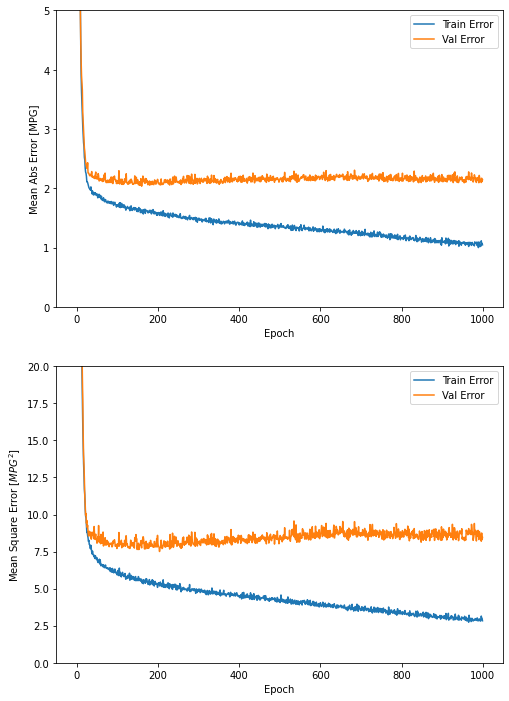

In [35]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)


............................................

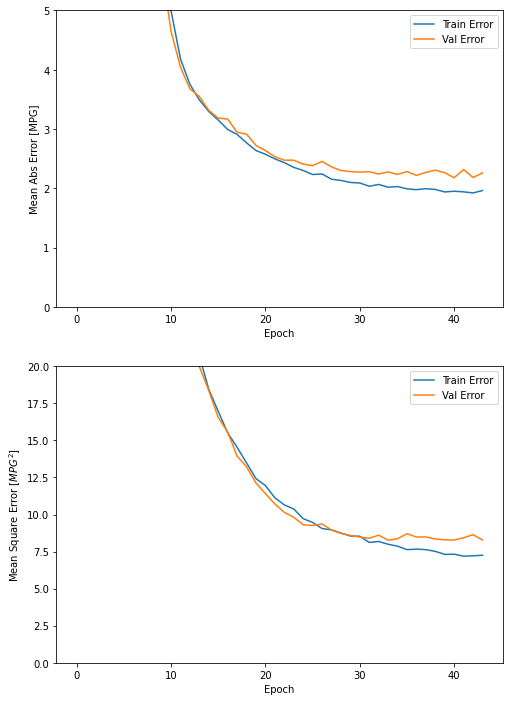

In [36]:
model = build_model()

# patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [37]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.7432 - mae: 1.7837 - mse: 5.7432
테스트 세트의 평균 절대 오차:  1.78 MPG



....................................................................................................
........

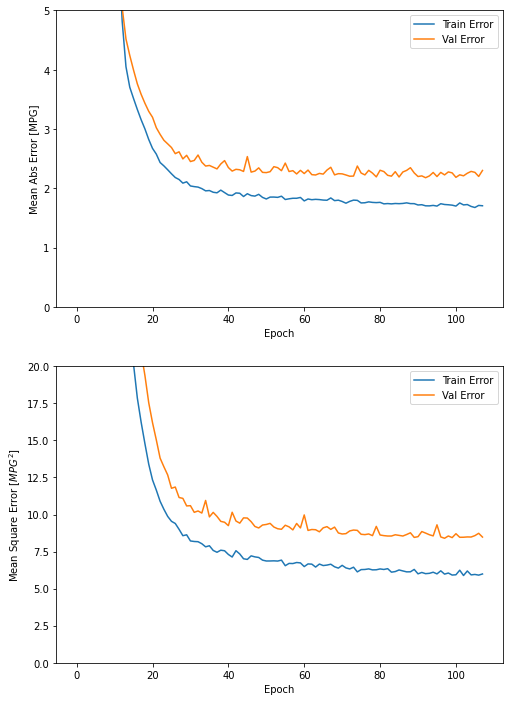

In [39]:
model = build_model()

# patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(train_dataset_onethot, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [40]:
loss, mae, mse = model.evaluate(test_dataset_onethot, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 6.0405 - mae: 1.8665 - mse: 6.0405
테스트 세트의 평균 절대 오차:  1.87 MPG
